# Определение стоимости автомобилей

В данном проекте необходимо смоделировать модель, с помощью которой можно будет быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Подключим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics.scorer import make_scorer
from sklearn.tree import DecisionTreeRegressor

Загрузим и изучим данные:

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


В наших данных 16 прихнаков:
*	DateCrawled — дата скачивания анкеты из базы
*	VehicleType — тип автомобильного кузова
*	RegistrationYear — год регистрации автомобиля
*	Gearbox — тип коробки передач
*	Power — мощность (л. с.)
*	Model — модель автомобиля
*	Kilometer — пробег (км)
*	RegistrationMonth — месяц регистрации автомобиля
*	FuelType — тип топлива
*	Brand — марка автомобиля
*	NotRepaired — была машина в ремонте или нет
*	DateCreated — дата создания анкеты
*	NumberOfPictures — количество фотографий автомобиля
*	PostalCode — почтовый индекс владельца анкеты (пользователя)
*	LastSeen — дата последней активности пользователя
*	Price — цена (евро)

Далее посмотрим, в каких столбцах присутствуют пропуски:


In [5]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0 : 'missing values'})
report['% of total'] = (report['missing values'] / data.shape[0]).round(2)
report.style.background_gradient(cmap = 'RdPu')

,missing values,% of total
DateCrawled,0,0
Price,0,0
VehicleType,37490,0.11
RegistrationYear,0,0
Gearbox,19833,0.06
Power,0,0
Model,19705,0.06
Kilometer,0,0
RegistrationMonth,0,0
FuelType,32895,0.09


Все признаки, в которых мы нашли пропуски, категориальные, значит на статистические данные мы их не заменим. Предлагаю заполнить их словом “unknown”. Это лучше, чем удалить большой объём данных. Но все же немного данных мы удалим, удалим строки, в которых пропуски во всех 5ти признаках, такие строки могут сильно запутать модель.

In [6]:
# выберем строки, в которых отсутствуют значения сразу в 5-ти еаших признаков
col_name = list(report[report['missing values'] != 0].index)
col_name
row_for_drop = data
for col in col_name:
    row_for_drop = row_for_drop[row_for_drop[col].isna()]
print(f'Доля ячеек, где пропуске во всех пяти признаках: {row_for_drop.shape[0] / data.shape[0]:.2%}')

Доля ячеек, где пропуске во всех пяти признаках: 0.63%


Меньше процента, удаляем без зазрения совести.

In [7]:
# удаляем объекты из датасета
data.drop(index = row_for_drop.index, inplace=True)

# обновляем индексы
data.reset_index(drop=True, inplace=True)

# заполняем пропуски ключевым словом:
data.fillna('unknown',inplace=True)

In [8]:
# проверим, от всех ли пропусков удалось избавиться 
report = data.isna().sum().to_frame()
report = report.rename(columns = {0 : 'missing values'})
report['% of total'] = (report['missing values'] / data.shape[0]).round(2)
report.style.background_gradient(cmap = 'RdPu')

,missing values,% of total
DateCrawled,0,0
Price,0,0
VehicleType,0,0
RegistrationYear,0,0
Gearbox,0,0
Power,0,0
Model,0,0
Kilometer,0,0
RegistrationMonth,0,0
FuelType,0,0


С пропусками разобрались. Переходим к поиску и устранению аномальных значений, которые могут ухудшить нашу модель.

In [9]:
# заранее определим стиль для наших графиков
plt.style.use('ggplot')

In [10]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,352132.000000,352132.000000,352132.000000,352132.000000,352132.000000,352132.0,352132.000000
mean,4437.540570,2003.871636,110.720108,128438.071519,5.746422,0.0,50534.888428
std,4516.540446,70.673430,190.249667,37562.896848,3.712289,0.0,25778.993977
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30167.000000
50%,2750.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49429.000000
75%,6450.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71093.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Сразу на глаза попадаются странные значения. Разберём каждый признак по отдельности.

Признак 'Price' - наш целевой. построим график распределения значений.

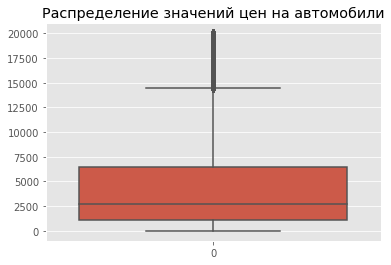

In [11]:
# признак 'Price' - наш целевой
ax =  sns.boxplot(data=data['Price'])
ax.set_title('Распределение значений цен на автомобили');


Цена в 20000 евро за машину хоть и выбивается из общей картины, но она вполне реальна, так что убирать эти значения из выборки мы не будем. А вот со всем количеством бесплатных и почти бесплатных машин нужно что-то делать. Предлагаю отрезать 5% квантиль из наших данных.

In [12]:
data['Price'].quantile(.05)

200.0

За 200 евро уже реально найти хоть какую-то машину.

In [13]:
data = data[data['Price'] > data['Price'].quantile(.05)]

Далее переходим к столбцу "RegistrationYear".

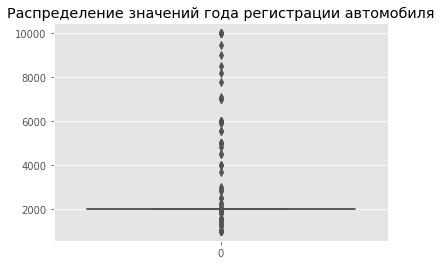

In [14]:
ax =  sns.boxplot(data=data['RegistrationYear'])

ax.set_title('Распределение значений года регистрации автомобиля');

На графике видны выбросы в обе стороны, предлагаю откинуть значения, которые не входят в диапазон [1.5% квантиль; 2021 (настоящее время)].

In [15]:
year_range = [int(data['RegistrationYear'].quantile(.015)), 2021]

print(year_range)

[1985, 2021]


In [16]:
data.drop(data[(data['RegistrationYear'] > year_range[1]) | (data['RegistrationYear'] < year_range[0])].index, inplace=True)

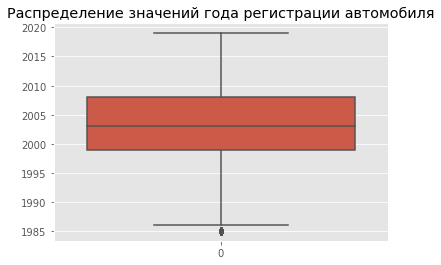

In [17]:
ax =  sns.boxplot(data=data['RegistrationYear'])

ax.set_title('Распределение значений года регистрации автомобиля');

Далее рассмотрим значения мощности автомобиля.

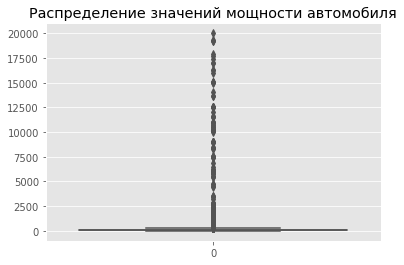

In [18]:
ax =  sns.boxplot(data=data['Power'])

ax.set_title('Распределение значений мощности автомобиля');

Очень много машин, в которых двигатель на 0 л.с. Что же нам с ними делать? Удалить такой большой объём данных было бы неправильно. Я предлагаю следующее решение:
* Возьмём диапазон допустимых значений силы двигателей [50; 800] л.с. (снизу прикрепил ссылку на источник, откуда взял данный диапазон).
* Значения, которые не попали в данных диапазон мы обнуляем.
* Затем наш датасет сортируем по марке и модели автомобиля и заполняем пропуски соседними значениями (допустим, что машины одной модели должны иметь одинаковую мощность двигателя характеристики).


<a href="https://zap-online.ru/info/avtonovosti/chto-budet-esli-v-dvigatele-svoego-avtomobilya-ya-ostavlyu-vsego-odnu-loshadinuyu-silu#:~:text=%D0%A1%D0%BE%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9%20%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C%20%D0%B8%D0%BC%D0%B5%D0%B5%D1%82%20%D0%B4%D0%B2%D0%B8%D0%B3%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%20%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C%D1%8E,4%20%D0%BB%D0%B8%D1%82%D1%80%D0%B0%20%D0%BD%D0%B0%20100%20%D0%BA%D0%B8%D0%BB%D0%BE%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2." class="global">Источник, с которого бралась информация об объёмах двигателей автомобилей</a>


In [19]:
data['Power'] = data['Power'].apply(lambda Power: Power if (Power < 800) & (Power > 50) else np.nan)

In [20]:
data = data.sort_values('Brand').sort_values('Model').ffill()

In [21]:
# перемешаем наши отсортированные данные:
data = data.sample(frac=1, random_state=30050).reset_index(drop=True)

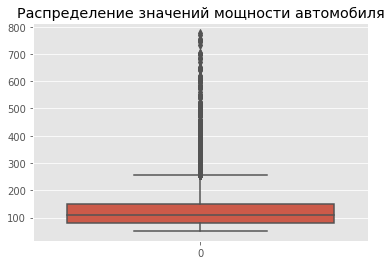

In [22]:
ax =  sns.boxplot(data=data['Power'])

ax.set_title('Распределение значений мощности автомобиля');

Выбросы ещё остались, но убирать мы их не будем. Если мы их уберем, это будет означать, что мы закрыли глаза на автомобили спортивные автомобили, а нам важно обучить нашу модель предсказывать цены для всех классов машин.

Переходим к пробегу автомобилей.

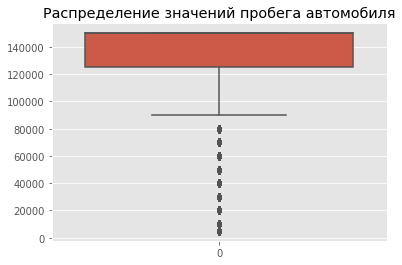

In [23]:
ax =  sns.boxplot(data=data['Kilometer'])

ax.set_title('Распределение значений пробега автомобиля');

Медиана и максимум равны. Интересно, с чем это связано, может в анкете на машину нельзя ставить более 150 тыс. км. или люди немного врут, не хотя давать огласке тот факт, что машина повидала уже многое. В любом случае странных значений я тут не наблюдаю, так что предлагаю оставить данные столбец в исходном состоянии.

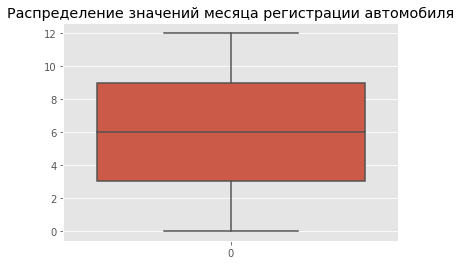

In [24]:
ax =  sns.boxplot(data=data['RegistrationMonth'])

ax.set_title('Распределение значений месяца регистрации автомобиля');

Какое красивое распределение, для наглядности выведем таблицу с долями машин, зарегистрированными в разные месяца.

In [25]:
(data['RegistrationMonth'].value_counts() / data.shape[0]).round(2).to_frame().style.background_gradient(cmap = 'RdPu')

,RegistrationMonth
3,0.1
6,0.09
4,0.08
0,0.08
5,0.08
7,0.08
10,0.08
11,0.07
12,0.07
9,0.07


У нас появился новый тринадцатый (нулевой) месяц. Наверно, никто бы не отказался от такого подарка, но в реальной жизни пока лишь 12 месяцев в году. Я предлагаю вообще удалить этот столбец из нашей таблицы. Обычно, при покупке/продаже, для составления цены хватает информация о годе выпуска машины. Я считаю, что месяц – это лишнее.

In [26]:
data = data.drop('RegistrationMonth', axis=1)

И последний признак: 'NumberOfPictures'. Тут все просто, мы просто удалим его. Почему? Потому что он весь состоит из нулей. Зачем нам это нужно.

In [27]:
data = data.drop('NumberOfPictures', axis=1)

Ещё раз посмотрим на распределение значений наших признаков.

In [28]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,PostalCode
count,329054.000000,329054.000000,329054.000000,329054.000000,329054.000000
mean,4646.535593,2003.711038,121.581667,129004.236387,50782.274198
std,4499.546538,6.312780,53.193497,36551.141290,25686.433186
min,202.000000,1985.000000,51.000000,5000.000000,1067.000000
25%,1290.000000,1999.000000,80.000000,125000.000000,30539.000000
50%,2980.000000,2003.000000,111.000000,150000.000000,49596.000000
75%,6600.000000,2008.000000,150.000000,150000.000000,71263.000000
max,20000.000000,2019.000000,776.000000,150000.000000,99998.000000


Выглядит намного лучше, от выбросов избавились. 

Давайте ещё раз выведем информацию о наших двнных.

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329054 entries, 0 to 329053
Data columns (total 14 columns):
DateCrawled         329054 non-null object
Price               329054 non-null int64
VehicleType         329054 non-null object
RegistrationYear    329054 non-null int64
Gearbox             329054 non-null object
Power               329054 non-null float64
Model               329054 non-null object
Kilometer           329054 non-null int64
FuelType            329054 non-null object
Brand               329054 non-null object
NotRepaired         329054 non-null object
DateCreated         329054 non-null object
PostalCode          329054 non-null int64
LastSeen            329054 non-null object
dtypes: float64(1), int64(4), object(9)
memory usage: 35.1+ MB


### Вывод

Мы провели предобработку данных:
* Изучили наши данные.
* Обнаружили и избавились от пропусков в данных. 
* Обнаружили и избавились от аномальных значений

Далее, переходим к обучению модели.

## Обучение моделей

Переходим к обучению. Для начала поделим наши выборки на trein/test/valid. 

Не все признаки мы будем использовать для обучения. Нам не понадобится:

* почтовый индекс владельца анкеты (пользователя)
* дата последней активности пользователя
* дата создания анкеты
* дату скачивания анкеты из базы. 

Перед разделением данных на выборки закодируем наши категориальные признаки.

In [30]:
data_ordinal = data
col_name = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
data[col_name] = encoder.fit_transform(data[col_name])

In [31]:
data_ordinal.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-23 17:52:45,1890,7.0,2016,2.0,150.0,95.0,150000,2.0,20.0,0.0,2016-03-23 00:00:00,49419,2016-03-23 17:52:45
1,2016-04-03 09:00:20,2000,2.0,1999,2.0,150.0,11.0,150000,6.0,2.0,2.0,2016-04-03 00:00:00,63679,2016-04-03 09:48:22
2,2016-03-26 14:36:44,899,7.0,2016,0.0,60.0,226.0,150000,7.0,32.0,1.0,2016-03-26 00:00:00,26345,2016-04-06 03:44:18
3,2016-03-22 22:54:51,1770,4.0,1999,0.0,170.0,164.0,150000,4.0,24.0,0.0,2016-03-22 00:00:00,85774,2016-04-03 04:45:53
4,2016-03-25 12:51:52,1550,4.0,1996,1.0,150.0,59.0,150000,6.0,20.0,1.0,2016-03-25 00:00:00,38162,2016-03-28 12:16:15
5,2016-03-22 14:54:36,8650,4.0,2003,1.0,218.0,15.0,150000,2.0,2.0,1.0,2016-03-22 00:00:00,84130,2016-03-22 14:54:36
6,2016-03-17 16:36:57,8590,0.0,2008,1.0,150.0,236.0,100000,6.0,20.0,0.0,2016-03-17 00:00:00,87439,2016-04-07 01:16:51
7,2016-03-28 22:36:16,7999,0.0,2009,1.0,140.0,220.0,150000,2.0,38.0,1.0,2016-03-28 00:00:00,93096,2016-04-05 12:45:57
8,2016-03-06 17:48:07,850,5.0,2002,1.0,64.0,173.0,150000,6.0,38.0,2.0,2016-03-06 00:00:00,66399,2016-04-06 22:15:37
9,2016-03-16 14:56:51,15900,4.0,2012,1.0,136.0,6.0,60000,6.0,2.0,0.0,2016-03-16 00:00:00,45699,2016-04-06 16:44:55


In [32]:
features = data_ordinal.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'Price'], axis=1)
target = data_ordinal['Price']

features_train, features_other, target_train, target_other = train_test_split(
        features, target, test_size=0.4, random_state=30050)
features_valid, features_test, target_valid, target_test = train_test_split(
        features_other, target_other, test_size=0.5, random_state=30050)

del features_other
del target_other

print(f'Train sample size: {features_train.shape}, {target_train.shape}')
print(f'Valid sample size: {features_valid.shape}, {target_valid.shape}')
print(f'Test sample size: {features_test.shape}, {target_test.shape}')

Train sample size: (197432, 9), (197432,)
Valid sample size: (65811, 9), (65811,)
Test sample size: (65811, 9), (65811,)


Далее нам предстоит обучить разные модели: 
* DecisionTreeRegressor
* RandomForestRegressor
* LGBMRegressor
Для каждой попробуем разные параметры и выберем лучшую. Начнём с дерева решений.

In [33]:
model = DecisionTreeRegressor(random_state=30050).fit(features_train, target_train)
predictions = model.predict(features_valid)
print(mean_squared_error(target_valid, predictions)**0.5)

2020.0961346373344


Подберём разные параметры к нашей модели и пасмотрим, как изменится метрика.

In [34]:
best_results = 3000
best_depth = 0
for depth in [1,10,100]:
    model = DecisionTreeRegressor(random_state=30050, max_depth=depth).fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    if rmse < best_results:
        best_results = rmse
        best_depth = depth
print('Best model:')
print(f'max_depth = {best_depth}, RMSE = {best_results}')

Best model:
max_depth = 10, RMSE = 2001.4684932300981


Рассмотрим диапазон глубины деревьев от 20 до 100 с шагом 20.

In [35]:
best_results = 3000
best_depth = 0
for depth in range(20,100,20):
    model = DecisionTreeRegressor(random_state=30050, max_depth=depth).fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    if rmse < best_results:
        best_results = rmse
        best_depth = depth
print('Best model:')
print(f'max_depth = {best_depth}, RMSE = {best_results}')

Best model:
max_depth = 20, RMSE = 1997.0089405074502


Лучшее значение RMSE мы получили при значении max_depth = 40. Затем, при увеличении значения глубины дерева, метрика не улучшается. Далее посмотрим, как себя покажет случайный лес.

In [36]:
model = RandomForestRegressor(random_state=30050).fit(features_train, target_train)
predictions = model.predict(features_valid)
print(mean_squared_error(target_valid, predictions)**0.5)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1682.3560325313972


Значение метрики качества лучше, чем у дерева решений. Попробуем подберать параметры, возможно, метрика качества станет ещё лучше. Проверим это.

In [37]:
best_results = 3000
estimator = 0
for n_estimators in [10, 30, 50]:
    model = RandomForestRegressor(random_state=30050, n_estimators=n_estimators).fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    if rmse < best_results:
        best_results = rmse
        estimator = n_estimators
print('Best model:')
print(f'n_estimators = {estimator}, RMSE = {best_results}')

Best model:
n_estimators = 50, RMSE = 1635.5843396633352


Лучше всего себя показала модель с 50 деревьями, останавимся на этом значении, далее подберём значение глубины.

In [38]:
best_results = 3000
best_depth = 0
for depth in [1,30, 50]:
    model = RandomForestRegressor(random_state=30050, n_estimators=50, max_depth=depth).fit(features_train, target_train)
    predictions = model.predict(features_valid)
    if rmse < best_results:
        best_results = rmse
        best_depth = depth
print('Best model:')
print(f'max_depth = {best_depth}, RMSE = {best_results}')

Best model:
max_depth = 1, RMSE = 1635.5843396633352


Нашей модель с 50 деревьями лучше всего себя показала при значении глубины равным 30, далее метрика качества уже не изменяется. RMSE меньше, чем у DecisionTreeRegressor.

Далее рассмотрим последнюю модель: модель градиентного бустинга из библиотеки LightGBM.

In [39]:
# список категориальных признаков
cat_column = {'Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType'}

In [40]:
model = LGBMRegressor(random_state=30050).fit(
    features_train, target_train, categorical_feature=cat_column)
predictions = model.predict(features_valid)
print(mean_squared_error(target_valid, predictions)**0.5)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


1620.2080414504012


RMSE у модели градиентного бустинга самое маленькое. А мы попробуем его ещё улучшить.

In [41]:
# Подберем значения количество листьев дерева.
best_results = 3000
best_leaves = 0

for leaves in [5,100, 500]:
    model = LGBMRegressor(random_state=30050, num_leaves=leaves).fit(
        features_train, target_train, categorical_feature=cat_column)
    predictions = model.predict(features_valid)
    if rmse < best_results:
        best_results = rmse
        best_leaves = leaves
print('Best model:')
print(f'best_leaves = {leaves}, RMSE = {best_results}')

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Best model:
best_leaves = 500, RMSE = 1635.5843396633352


Модель с 500 листьями показала лучшее значение метрики RMSE, далее построим модели с разным количеством деревьев и посмотрим на метрику качества.

In [42]:
best_results = 3000
estimator = 0

for estimators in [10, 100, 200, 500]:
    model = LGBMRegressor(random_state=30050, n_estimators=estimators, num_leaves=500).fit(
        features_train, target_train, categorical_feature=cat_column)
    predictions = model.predict(features_valid)
    if rmse < best_results:
        best_results = rmse
        estimator = n_estimators
print('Best model:')
print(f'n_estimators = {estimator}, RMSE = {best_results}')

Best model:
n_estimators = 50, RMSE = 1635.5843396633352


### Вывод

В итоге модель градиентного бустинга с 200 деревьями и 500 листьями показала себя лучше всех. Так что дальше мы переходим к анализу работы этой модели на тестовой выборке.

## Анализ моделей

Перейдём к анализу нашей модели
проверим наши модель на тестовой выборке, проверим её на вменяемость и проанализируем скорость работы (сравним скорость работы модели с 100 и с 200 деревьями, так как метрика RMSE у них не сильно отличаются).

In [65]:
%%time

#обучим нашу модель, посмотрим на время обучения
model_200 = LGBMRegressor(random_state=30050, num_leaves=500, n_estimators=200).fit(
    features_train, target_train, categorical_feature=cat_column)

CPU times: user 1min 29s, sys: 803 ms, total: 1min 30s
Wall time: 1min 31s


In [66]:
%%time

#обучим нашу модель, посмотрим на время обучения
model_100 = LGBMRegressor(random_state=30050, num_leaves=500, n_estimators=100).fit(
    features_train, target_train, categorical_feature=cat_column)

CPU times: user 27.9 s, sys: 331 ms, total: 28.2 s
Wall time: 28.6 s


In [67]:
%%time

# посмотрим на время предсказаний и их качество на тестовой выборке
predictions = model_200.predict(features_test)
mean_squared_error(target_test, predictions)**0.5

CPU times: user 6 s, sys: 9.89 ms, total: 6.01 s
Wall time: 6.02 s


1522.2911751391719

In [69]:
%%time

# посмотрим на время предсказаний и их качество на тестовой выборке
predictions = model_100.predict(features_test)
mean_squared_error(target_test, predictions)**0.5

CPU times: user 3.16 s, sys: 754 µs, total: 3.16 s
Wall time: 3.13 s


1526.2822730815083

Далее проверим нашу модель на вменяемость (сравним её со случайной моделью, которая будет заполнять все средними значениями)

In [48]:
model = DummyRegressor(strategy='mean').fit(features_train, target_train)
predictions = model.predict(features_test)
mean_squared_error(target_test, predictions)**0.5

4491.055606265102

In [2]:
import time
start_time = time.time()
a = 2 + 2
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.487701416015625e-05 seconds ---


## Вывод

Мы построили модель для определения стоимости автомобиля. Модель мы построили на данных, с которыми предварительно провели предобработку (побороли пропуски и выбросы). Тестировали мы 3 модели: 
* DecisionTreeRegressor
* RandomForestRegressor
* LGBMRegressor

Лучшее значение метрики качества показала модель градиентного бустинга. Для улучшения точности предсказаний мы подбирали два гиперпараметра, это  'num_leaves' и  'n_estimators'. Лучшую точность показала модель с параметрами num_leaves = 500 и  n_estimators = 200, но она не RMSE данной модели не сильно отличается от модель с num_leaves = 500 и  n_estimators = 100. Так что анализ мы будем проводить с двумя моделями. Обе модели прошли проверку на вменяемость. Модель DummyRegressor, которая предсказывала средними значениями показала метрику RMSE, которая в 3 раза больше, чем у нашей модели. Результаты анализа наших моделей.

Модель градиентного бустинга с 200 деревьями: 
* время обучения = 48.2 с
* время предсказывания = 4.7 с
* RMSE = 1522

Модель градиентного бустинга с 100 деревьями: 
* время обучения = 25.8 с
* время предсказывания = 1.6 с
* RMSE = 1526

Эти значения говорят нам о том, что модель градиентного бустинга с 100 деревьями почти в 2 раза быстрее обучается и в 3 раза быстрее предсказывает, чем модель с 200 деревьями. Но при этом на тестовой выборке ошибка этой модели лишь на 2.6% больше соперницы. Так как задача была: добавить возможность быстро узнать рыночную стоимость своего автомобиля, я советую для сервиса по продаже автомобилей выбрать модель, которая предсказывает в 3 раза быстрее.
